# Implementation of ResNet-50 Model

In [61]:
import os
import sys
import time
import copy
from pathlib import Path

import cv2
import torch
import torch.nn as nn
import torchvision as vision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import random
import numpy as np
import matplotlib
from matplotlib import pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (32.0, 32.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [62]:
# Global Vars
device = 'cpu'

path = '../../Datasets/ImageNet-Sketch/sketch'
custom_path = '../../Datasets/Custom'
class_paths = [f for f in Path(path).glob('*')]
image_paths = [f for f in Path(path).glob('*\*.JPEG')]
num_classes = len(class_paths)
dataset_total_size = len(image_paths)

image_size = 224
batch_size = 32
epochs = 10
feature_extract = True

print('PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('CUDA available')
    device='cuda'
else:
    print('WARNING: CUDA is not available')
    device='cpu'

print(os.getcwd())

PyTorch version: 1.10.1
CUDA available
c:\Users\Admin\Desktop\Tharja\Term 7\CV\50.039-CV-Project\Models\ResNet-50


In [63]:
print(f'# Classes: {num_classes}')
print(f'# Images: {dataset_total_size}')
print(class_paths[:10])

# Classes: 1000
# Images: 50889
[WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01440764'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01443537'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01484850'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01491361'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01494475'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01496331'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01498041'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01514668'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01514859'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01518878')]


In [64]:
# get class mapping
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, class_dict = find_classes(path)
print(classes[:10], {k: class_dict[k] for k in list(class_dict)[:10]})

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878'] {'n01440764': 0, 'n01443537': 1, 'n01484850': 2, 'n01491361': 3, 'n01494475': 4, 'n01496331': 5, 'n01498041': 6, 'n01514668': 7, 'n01514859': 8, 'n01518878': 9}


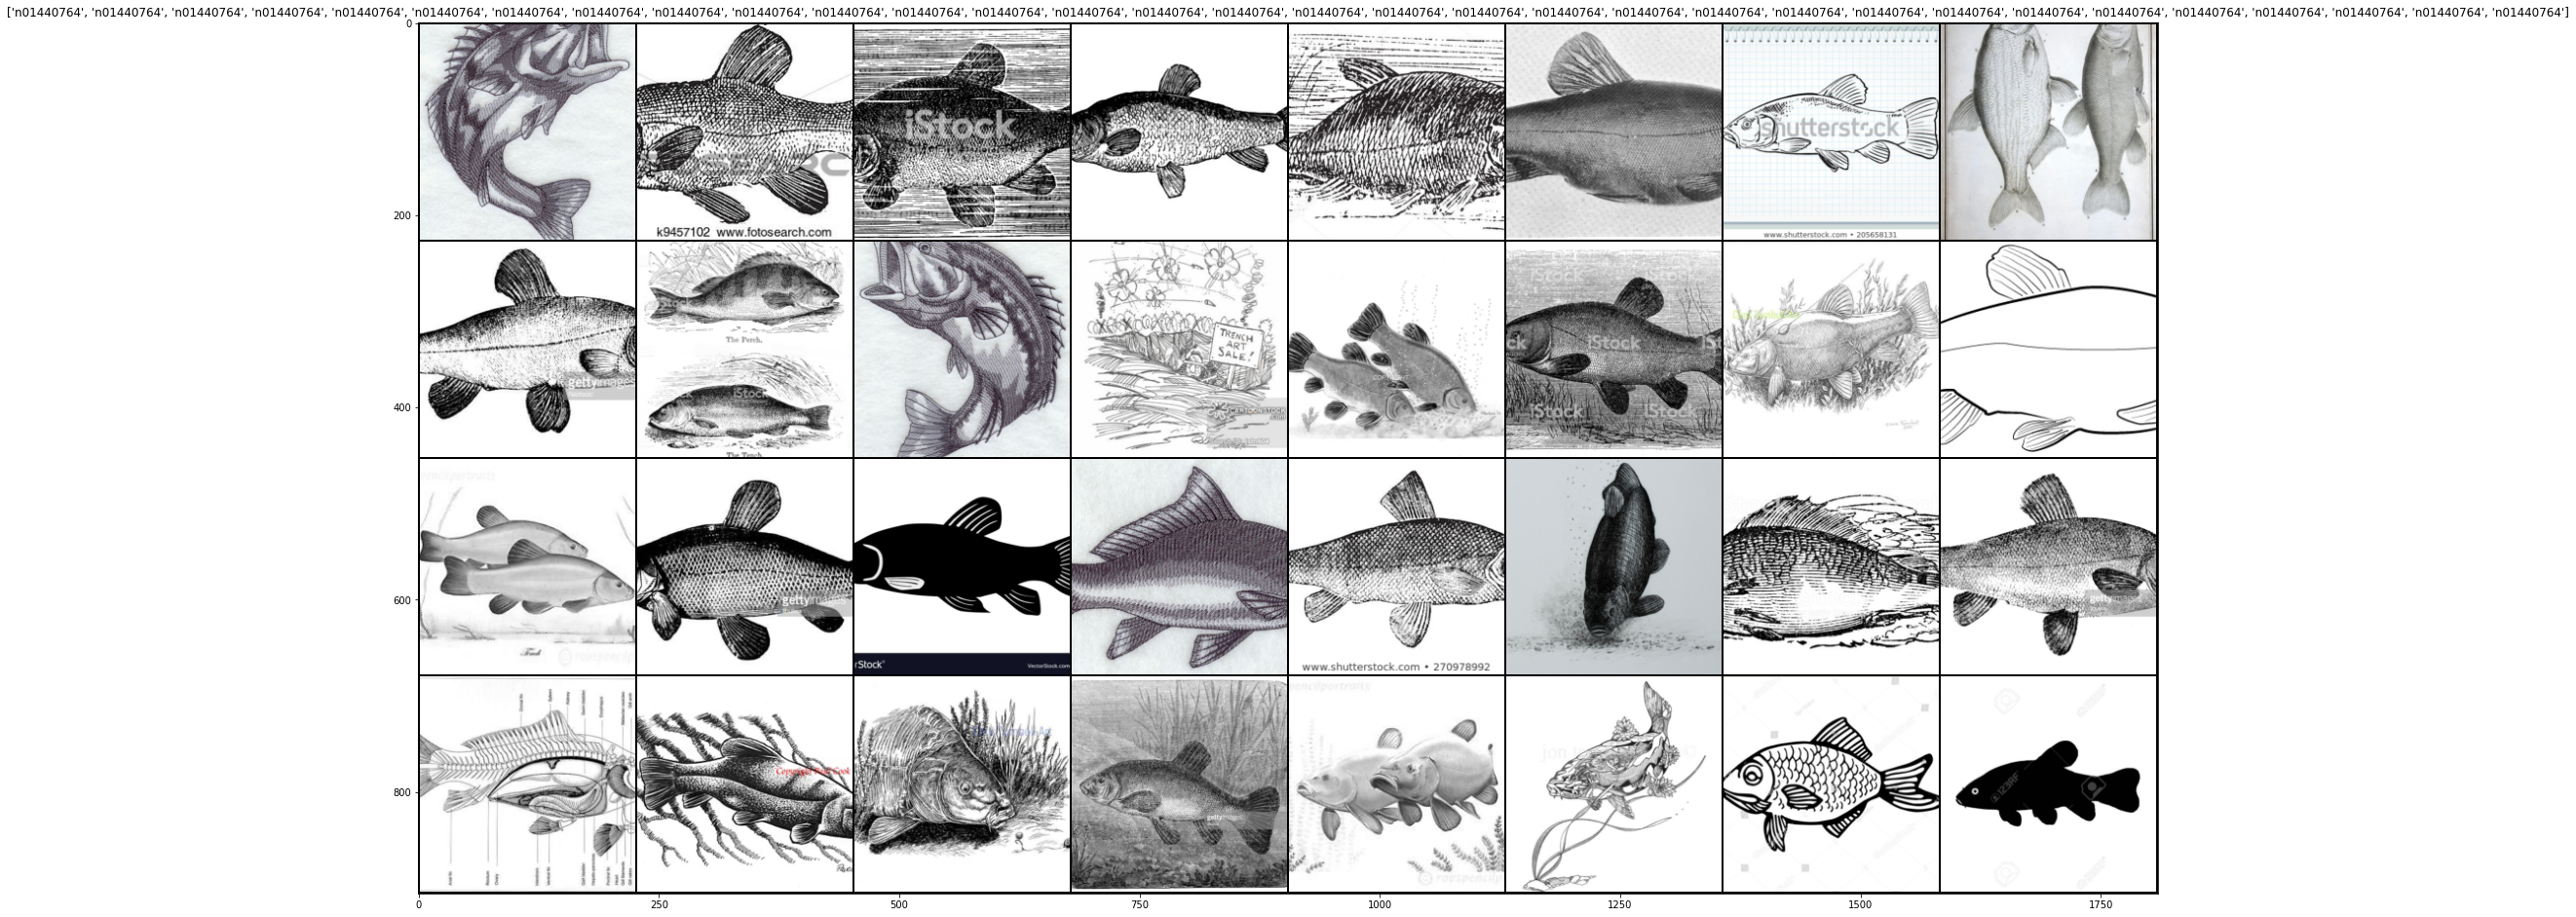

In [65]:
# Test loading in the data
idx = random.randint(0, 999)
transform = transforms.Compose([transforms.Resize(image_size+1),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor()])

full = datasets.ImageFolder(path, transform=transform)
full_dataloader = DataLoader(full, batch_size=batch_size, shuffle=False)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels = next(iter(full_dataloader))

# Make a grid from batch
out = vision.utils.make_grid(inputs)
imshow(out, title=[classes[x] for x in labels])


In [66]:
# split dataset into train and test sets
train, test = torch.utils.data.random_split(full, [int(dataset_total_size * 0.8), dataset_total_size - int(dataset_total_size * 0.8)], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=4)

# put datasets into a dictionary
dataloaders_dict = {'train': train_dataloader, 'test': test_dataloader}

In [67]:
# load validation dataset from the /Datasets/Custom

In [68]:
# define ResNet-50 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

Using cache found in C:\Users\Admin/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [69]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(model, feature_extract)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
input_size = image_size

model = model.to(device)

In [70]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=epochs, is_inception=False):
    since = time.time()

    test_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # print(f'Epoch {epoch}, {phase} phase running loss: {running_loss}')

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history

In [71]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [72]:
# Train and Validate
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=epochs)

Epoch 0/9
----------
train Loss: 6.6047 Acc: 0.0396
test Loss: 6.1893 Acc: 0.1284

Epoch 1/9
----------
train Loss: 5.8444 Acc: 0.1938
test Loss: 5.5000 Acc: 0.2403

Epoch 2/9
----------
train Loss: 5.1841 Acc: 0.3027
test Loss: 4.9157 Acc: 0.3090

Epoch 3/9
----------
train Loss: 4.6223 Acc: 0.3742
test Loss: 4.4390 Acc: 0.3479

Epoch 4/9
----------
train Loss: 4.1584 Acc: 0.4252
test Loss: 4.0244 Acc: 0.3667

Epoch 5/9
----------
train Loss: 3.7776 Acc: 0.4618
test Loss: 3.7254 Acc: 0.3981

Epoch 6/9
----------
train Loss: 3.4669 Acc: 0.4924
test Loss: 3.4602 Acc: 0.4209

Epoch 7/9
----------
train Loss: 3.2130 Acc: 0.5178
test Loss: 3.2556 Acc: 0.4349

Epoch 8/9
----------
train Loss: 2.9996 Acc: 0.5375
test Loss: 3.1562 Acc: 0.4430

Epoch 9/9
----------
train Loss: 2.8204 Acc: 0.5561
test Loss: 3.0046 Acc: 0.4619

Training complete in 24m 18s
Best test Acc: 0.461879
